# pytorch Gradients

In this reading, we'll introduce pytorch.  It is similar to numpy (with `tensor`s instead of `array`s),  but with two additional very important features:

1. ability to run on a GPU
2. ability to compute gradients automatically

We'll give a brief intro to tensors, then focus on that second functionality.

Let's look at some tensors.  A tensor might be a simple scalar...

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from torch import tensor, cuda

x = tensor(3.0)
x * 2

tensor(6.)

Or a matrix or vector (or other multi-dimensional structure):

In [2]:
X = tensor([[1,2], [3,4]])
c = tensor([10, 1])
X

tensor([[1, 2],
        [3, 4]])

In [3]:
X

tensor([[1, 2],
        [3, 4]])

In [4]:
c

tensor([10,  1])

We can do element-wise operations and dot products, just like with numpy arrays.

In [5]:
X * 10

tensor([[10, 20],
        [30, 40]])

In [6]:
X @ c.reshape(-1,1)

tensor([[12],
        [34]])

We can convert any numpy array to a pytorch tensor:

In [7]:
X = np.array([[1,2], [3,4]])
X

array([[1, 2],
       [3, 4]])

In [8]:
X = tensor(X)
X

tensor([[1, 2],
        [3, 4]])

Unlike numpy arrays, which always reside in main memory, directly accessible by the CPU, tensors can belong either to the CPU, or GPU:

In [9]:
X.device

device(type='cpu')

We won't do it in this reading, but when available, we can move our matrices to a compatible GPU.  This will make certain operations (like dot product of very large matrices) much faster.

In [10]:
if cuda.is_available():
    print("move to GPU")
    X = X.to("cuda")
else:
    print("no GPU available for our tensors :(")

no GPU available for our tensors :(


## Gradients

A *gradient* is a term for the slope at a particular point on a curve.  If you've taken a calculus class, you will have learned how to take the derivative of a function; a derivative is itself a function that can give a gradient at a particular point.  Gradients can be used for optimizations, such as maximization or minimization.  When we're creating a machine learning model, we'll want to minimize the mistakes it makes, for example.

Let's create `plot_func`, which can be used to visualize a function, such as `f`:

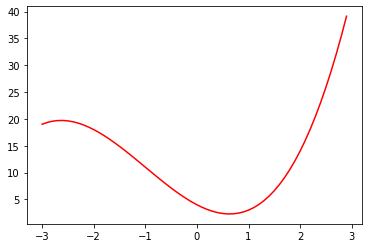

In [11]:
def plot_func(func, color="red"):
    x_vals = np.arange(-3, 3, 0.1)
    y_vals = func(x_vals)
    plt.plot(x_vals, y_vals, color)

def f(x):
    return x ** 3 + 3 * x ** 2 - 5 * x + 4

plot_func(f)

Let's also create a function to draw a line indicating the gradient at a particular point.

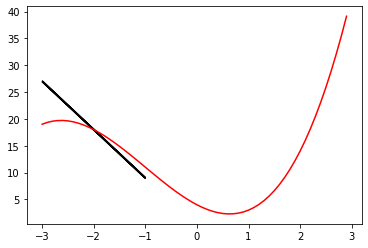

In [12]:
def plot_gradient(x, y, slope):
    x, y, slope = map(float, (x, y, slope))
    dx = 2
    dy = dx*slope
    plt.arrow(x-dx/2, y-dy/2, dx, dy, linewidth=2)
    
plot_func(f)
plot_gradient(x=-2, y=f(-2), slope=-9)

-9 was my guesstimate, and clearly it's a little off.  pytorch can calculate it for us if we use a scalar tensor for the x value instead of an int or float.

In [13]:
x = tensor(-2.0)
x

tensor(-2.)

In [14]:
y = f(x)
y

tensor(18.)

We should be able to get the gradient with `.grad`, as follows, but it's not currently set:

In [15]:
print(x.grad)

None


To have that attribute set, we need to (1) tell pytorch to start doing some extra tracking for calculations based on x (using `.requires_grad`) and (2) at the end tell it to compute the slope with respect to y (using `.backward`).  The idea of the second part is that there may be situations where we could compute both `y = f(x)` and `z = g(x)` -- we would need to clarify whether we want `x.grad` to be the `y/x` slope or the `z/x` slope.

In [16]:
x = tensor(-2.0).requires_grad_()
y = f(x)
y.backward()
slope = x.grad
slope

tensor(-5.)

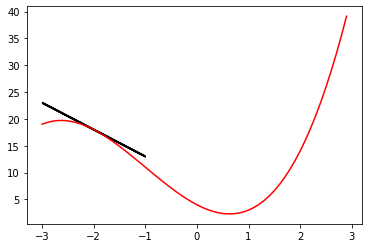

In [17]:
plot_func(f)
plot_gradient(x=x, y=y, slope=slope)

Besides `.requires_grad()`, `.backward()`, and `.grad`, one last thing we'll often use when working with gradients is `.grad.zero_()`.

This is sometimes necessary because `.backward()` doesn't just set `.grad` equal to the gradient, it adds the gradient to `.grad` (this is useful in some situations we won't cover in 320).

Here's an example of `.grad` being misused (with `.grad.zero_()`):

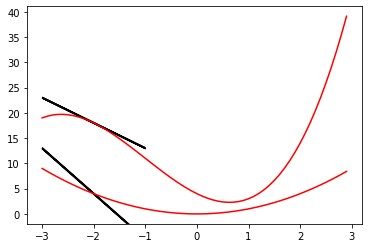

In [18]:
# plot both f + g
def g(x):
    return x ** 2

plot_func(f)
plot_func(g)

# draw the tangent line at x=-2 for f
x = tensor(-2.0).requires_grad_()
y = f(x)
y.backward()
plot_gradient(x=x, y=y, slope=x.grad)

# TODO: uncomment the following to correctly compute the slope for the g line
# x.grad.zero_()

# draw the tangent line at x=-2 for g
y = g(x)
y.backward()
plot_gradient(x=x, y=y, slope=x.grad)

tensor(-5.)
tensor(-4.)


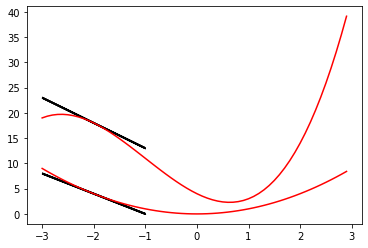

In [19]:
# plot both f + g
def g(x):
    return x ** 2

plot_func(f)
plot_func(g)

# draw the tangent line at x=-2 for f
x = tensor(-2.0).requires_grad_()
y = f(x)
y.backward()
print(x.grad)
plot_gradient(x=x, y=y, slope=x.grad)

x.grad.zero_()

# draw the tangent line at x=-2 for g
y = g(x)
y.backward()
print(x.grad)
plot_gradient(x=x, y=y, slope=x.grad)

# Conclusion

If you know from calculus how to compute a derivative, then you can plug in an x value and get a gradient.  pytorch can compute the gradient directly for us, as long as we make some extra method calls (`.requires_grad` on the input variable and `.backward()` on the output variable).

Gradients tell us the relation between two variables, which can help us optimize by slowly tweaking an input variable.  For example, if we're trying to minimize y, then a negative y/x gradient for a specific x value would tell us that making that x value a little bigger would help us make y a little smaller.